# Fantasy Hockey Draft

This notebook will simulate a fantasy hockey draft using Markowitz optimization stradegies, and also supports the possiblity of a human player. 

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import importlib
import sys

sys.path.insert(1, '../')
import scripts.hockey_bots as hockey

# need to keep reloading for development work because 
# I apparently like Jupyter too much 
importlib.reload(hockey)

<module 'scripts.hockey_bots' from '../scripts/hockey_bots.py'>

## Importing Data Created in `Data Wrangling.ipynb`

In [2]:
player_data = pd.read_csv("../data/player_data_for_optim3.csv")
# aggregate all scores into an array for each player
scores = player_data[['player_id', 'points',]].groupby('player_id').agg(lambda x: list(x)).reset_index()
all_points = pd.DataFrame(np.transpose(scores.points.tolist()), columns = scores.player_id)
idx = list(all_points.mean().sort_values(ascending=False).index)

## Finding Indexes
As we're only interested in aggregate inddexes of average player returns, we need to find each players index according to the aggregation, as well s the indexes of the players in each position done below.

In [3]:
# Finding index in an aggregate score for each position
pointies = list(all_points.mean().index)

defence = hockey.position_indexes(pointies,all_points,player_data,idx, "D")
center = hockey.position_indexes(pointies,all_points,player_data,idx, "C")
goalie = hockey.position_indexes(pointies,all_points, player_data,idx,"G")
right_wingers = hockey.position_indexes(pointies, all_points,player_data,idx,"RW")
left_wingers = hockey.position_indexes(pointies, all_points,player_data,idx,"LW")

## Running the Draft

Here we run the actual draft. Noe that `order` defines the order of the draft and automatically reverses after each round. Also note that the teams will be returned in the order that tay appear in the `functions` list in the final result. 

In [56]:
functions = [hockey.optim_player, 
             hockey.optim_player, 
             hockey.optim_player,
             hockey.optim_player, 
            hockey.optim_player, 
            hockey.optim_player, 
            hockey.optim_player,
            hockey.optim_player,
            hockey.greedy_competitor]

greedy_selections = {}
greedy_selections['goalie'] = []
greedy_selections['defence'] = []
greedy_selections['center'] = []
greedy_selections['right_winger'] = []
greedy_selections['left_winger'] = []


order = [8,1,2,3,4,5,0,7,6]

print(len(order), len(functions))

args = dict(scores = all_points, 
            gammaa = [0.01, 0.025, 0.03, 0.027, 0.031, 0.03, 0.03, .03], 
            greedy_selections = greedy_selections,
            df = player_data,
            defence = defence,
            goalie = goalie,
            center = center,
            left_wingers = left_wingers,
            right_wingers = right_wingers,
            selection = ['max', 'rms', 'max', 'rms', 'optim', 'optim', 'optim', 'optim'],
            sub_gamma = [None, None, None, None, .2, .8, .3, .4])
taken = []
all_players, teams = hockey.draft(functions, order, team_size=17, **args)

9 9
Beginning round 0
Beginning round 1
Beginning round 2
Beginning round 3
Beginning round 4
Beginning round 5
Beginning round 6
Beginning round 7
Beginning round 8
Beginning round 9
Beginning round 10
Beginning round 11
Beginning round 12
Beginning round 13
Beginning round 14
Beginning round 15
Beginning round 16
[]
{'goalie': [347, 6], 'defence': [201, 343, 489, 144, 143, 227, 226, 214, 206], 'center': [342, 50, 490, 127, 205], 'right_winger': [], 'left_winger': [202]}


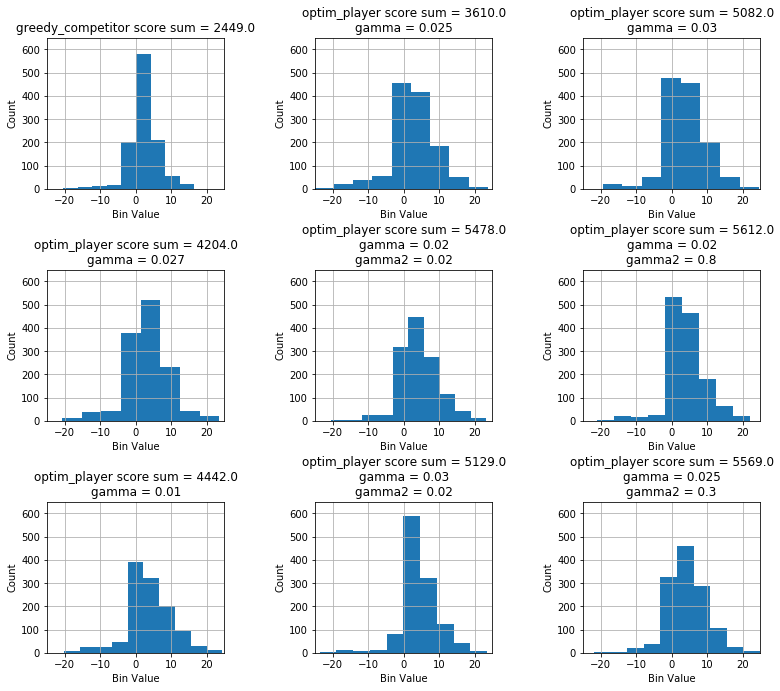

In [57]:
import matplotlib.pyplot as plt
test2 = pd.read_csv("../data/player_data_for_optim2.csv")
a = pd.read_csv("../data/texta.csv")
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(12, 10.5)
fig.tight_layout(pad =6)
for i in range(len(teams)):
    ohboy = test2[test2.player_id.isin(list(all_points.iloc[:,teams[order[i]]]))]
    playerids = ohboy.groupby('player_id').count().index

    lineup= a[a.player_id.isin(playerids)].groupby(['firstName', 'lastName', 'primaryPosition']).mean()
    #print(lineup['points'].sum())
    
#     print(a[a.player_id.isin(playerids)]['points'].mean(),
#           a[a.player_id.isin(playerids)]['points'].var())
    sum_score = a[a.player_id.isin(playerids)]['points'].sum()
    variance_score = a[a.player_id.isin(playerids)]['points'].std()
    a[a.player_id.isin(playerids)]['points'].hist(ax=ax[i//3, i%3])
    title = functions[order[i]].__name__ + " score sum = " + str(round(sum_score,0))
    gs = [0.01, 0.025, 0.03, 0.027, 0.02, 0.02, 0.025, .03, None]
    gs2 = [None, None, None, None, .02, .8, .3, .02, None]
    if functions[order[i]].__name__ == 'optim_player':
        title += "\ngamma = " + str(gs[order[i]]) 
        if gs2[order[i]]:
            title += "\ngamma2 = " + str(gs2[order[i]])
        
    ax[i//3, i%3].set_title(title)
    ax[i//3, i%3].set_ylim([0,650])
    ax[i//3, i%3].set_xlim([-25,25])
    ax[i//3, i%3].set_ylabel("Count")
    ax[i//3, i%3].set_xlabel("Bin Value")
                           
    # lineup

In [ ]:
### import matplotlib.pyplot as plt
gamm = np.linspace(0, .07, 20)
ret = []
risk = []
for gams in gamm:
    print(gams)
    p,risky,returny = hockey.optim_player(all_points,
                        [], [], .05, 
                        player_data, defence, goalie, center, 
                        right_wingers, left_wingers, full_team=True)
    ret.append(returny)
    risk.append(risky)
    break
    
ohboy = test2[test2.player_id.isin(list(all_points.iloc[:,p]))]
playerids = ohboy.groupby('player_id').count().index

lineup= a[a.player_id.isin(playerids)].groupby(['firstName', 'lastName', 'primaryPosition']).sum()
print(lineup['points'].sum())
lineup
    


In [ ]:
a[a.primaryPosition == 'G'].groupby(['firstName', 'lastName']).mean().sort_values(by='points', ascending=False)

In [ ]:
plt.plot(np.array(ret)/np.array(risk), gamm)